## Multimodal Few-Shot Learning for Image Captioning

Last biweekly report I did and introduction into zero, one, and few shot learning. For my second notebook this week I looked closer at few-shot learning in order to automatically caption images by following a tutorial presented at 
by dzryk (https://twitter.com/dzryk). The well-know paper "Multimodal Few-Shot Learning with Frozen Language Models" learns a vision network to connect to the token embedding space of a frozen language model. In this tutorial I followed we instead represent an image vector as a convex combination of existing token embeddings, where the weights are computed using openAI's CLIP. OpenAi and their GPT2 language model is also a tool I found last report and is extremely useful hub of code and information. 


In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!git clone https://github.com/openai/CLIP
!pip3 install transformers
!pip3 install ftfy

fatal: destination path 'CLIP' already exists and is not an empty directory.


In [3]:
import io
import numpy as np
import requests
import torch
import textwrap
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from CLIP import clip
from PIL import Image
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torchvision.utils import make_grid

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Useful functions

This tutorial fist gave us some helper functions that are not directly necessary to the architecture of the models but make loading the image, displaying the reslts, etc much easier so I just included them here for ease. 

In [5]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def load_image(img):
    img = Image.open(fetch(img))
    return img, preprocess(img).unsqueeze(0).to(device)


def get_tags(image, text_features, topk=10):
    image_features = model.encode_image(image).cpu().float()
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(topk)

    # Print the result
    #print("\nTop predictions:\n")
    #for value, index in zip(values, indices):
    #    print(f"{filtered_words[index]:>16s}: {100 * value.item():.2f}%")

    return indices, values


def get_lookup(indices, values, ntags=10):
    vocab = tokenizer.get_vocab()
    tags = [filtered_words[i] for i in indices]
    index = [vocab[char+t] for t in tags]
    lookup = gpt2.transformer.wte.weight.data[index]
    weights = (10.0 * values[:ntags]).softmax(dim=-1).to(device)
    lookup = (lookup[:ntags] * weights[:, None]).sum(0, keepdims=True)
    return lookup


def image_map(images, text_features, ntags=10):
    imgs = []
    imtensors = []
    lookups = []
    for pic in images:
        img, im = load_image(pic)
        indices, values = get_tags(im, text_features, topk=ntags)
        lookup = get_lookup(indices, values, ntags=ntags)
        imgs.append(img)
        imtensors.append(im)
        lookups.append(lookup)
    lookups = torch.vstack(lookups)
    return imgs, imtensors, lookups


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def cut(out, promptlen):
    if period_id in out[promptlen:]:
        return out[:promptlen+np.where(out[promptlen:] == period_id)[0][0]+1]
    else:
        return out


def display_grid(imgs, idxs):
    filtered_imgs = [imgs[i] for i in idxs]
    reshaped = [F.to_tensor(x.resize((256, 256))) for x in filtered_imgs]
    show(make_grid(reshaped))


def generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp):
    promptlen = len(input_ids[0])
    if sample:
        out = gpt2.generate(
            input_ids,
            max_length=promptlen+ngen,
            do_sample=True,
            top_p=top_p,
            temperature=temp,
            num_return_sequences=nsamples)
    else:
        out = gpt2.generate(
            input_ids,
            max_length=promptlen+ngen,
            num_beams=nbeams,
            num_return_sequences=1,
            no_repeat_ngram_size=2)
    return out.cpu()

## Task templates

Extending from what we learned from class, we are taking advantage in the following few shot learning models to train the caption generating model on very few training data points. Below we define the various tasks we want to run in our results section. The alternating task is able to describe what you are able to accomplish with whatever is depicted in the input image. In the binding task can categorize images binded as either dax or blicket. The knowledge example says an informational fact about the image using Gpt2 and the VQA provides a question answer given the input photo. Lastly, the caption task does a full image captioning as we intended at the beginning of this investigation. 

In [6]:
def two_shot_alternating_task(imgs, idxs, context, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8):
    prompt = f'{toks[idxs[0]]}. {context[0]} {toks[idxs[1]]}. {context[1]} {toks[idxs[2]]}. {context[2]}'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(cut(out[i], promptlen), skip_special_tokens=True), width=90)
        print(f'{text}\n')


def one_shot_binding_task(imgs, idxs, context, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8, name_a='dax', name_b='blicket'):
    prompt = f'Answer with {name_a} or {name_b}. {toks[idxs[0]]}. {context[0]} {toks[idxs[1]]}. {context[1]} {toks[idxs[2]]}. {context[2]}'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(cut(out[i], promptlen), skip_special_tokens=True), width=90)
        print(f'{text}\n')


def two_shot_binding_task(imgs, idxs, context, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8, name_a='dax', name_b='blicket'):
    prompt = f'Answer with {name_a} or {name_b}. {toks[idxs[0]]}. {context[0]} {toks[idxs[1]]}. {context[1]} {toks[idxs[2]]}. {context[2]} {toks[idxs[3]]}. {context[3]} {toks[idxs[4]]}. {context[4]}'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(cut(out[i], promptlen), skip_special_tokens=True), width=90)
        print(f'{text}\n')


def two_shot_binding_qa_task(imgs, idxs, context, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8, name_a='dax', name_b='blicket'):
    prompt = f'{toks[idxs[0]]}. {context[0]} {toks[idxs[1]]}. {context[1]} {toks[idxs[2]]}. {context[2]} {toks[idxs[3]]}. {context[3]} {toks[idxs[4]]}. {context[4]}'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(cut(out[i], promptlen), skip_special_tokens=True), width=90)
        print(f'{text}\n')


def zero_shot_vqa_task(imgs, idxs, context, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8):
    prompt = f'{toks[idxs[0]]}. Question: {context[0]}. Answer:'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(cut(out[i], promptlen), skip_special_tokens=True), width=90)
        print(f'{text}\n')


def caption_task(imgs, idxs, ngen=50, sample=True, nsamples=10, nbeams=1, top_p=0.95, temp=0.8):
    prompt = f'Describe this photo: {toks[idxs[0]]}. Description:'
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    promptlen = len(input_ids[0])
    out = generate(input_ids, ngen, sample, nsamples, nbeams, top_p, temp)
    display_grid(imgs, idxs)
    for i in range(len(out)):
        text = textwrap.fill(tokenizer.decode(out[i], skip_special_tokens=True), width=90)
        print(f'{text}\n')

## A collection of descriptive tags that exist inside GPT2 vocab as a single token.


In [7]:
filtered_words = ['fancy', 'general', 'plain', 'true', 'holiday', 'glamorous', 'dentist', 'library', 'car', 'majestic', 'middle', 'ample', 'equal', 'flawless', 'scarf', 'knowing', 'muddy', 'alloy', 'firewall', 'skate', 'false', 'dedication', 'veterinarian', 'trick', 'fine', 'security', 'clumsy', 'need', 'report', 'notable', 'shallow', 'wax', 'turbulent', 'act', 'ready', 'edge', 'upset', 'turn', 'canvas', 'mirror', 'manager', 'rod', 'stable', 'cast', 'far', 'snow', 'thorough', 'account', 'messy', 'coal', 'another', 'famous', 'harmless', 'desk', 'dream', 'pair', 'shoulder', 'swift', 'worst', 'team', 'vague', 'ocean', 'expensive', 'internal', 'bra', 'jar', 'ton', 'reliable', 'uneven', 'mouth', 'evil', 'reading', 'side', 'raven', 'drama', 'rusty', 'branch', 'law', 'joke', 'loose', 'authority', 'salesman', 'past', 'appendix', 'cloud', 'wealthy', 'possibility', 'crowd', 'respectful', 'growth', 'short', 'vessel', 'yarn', 'wretched', 'yearly', 'wool', 'fortunate', 'cooked', 'prepared', 'cooking', 'dress', 'honey', 'chill', 'acidic', 'beloved', 'helpless', 'vegetable', 'unfinished', 'cultured', 'shocking', 'save', 'brow', 'lobster', 'writer', 'kiss', 'bail', 'carbon', 'psychology', 'walk', 'wrench', 'defiant', 'support', 'secretary', 'minute', 'snail', 'bear', 'run', 'trail', 'thoughtful', 'eager', 'tame', 'novel', 'citizenship', 'hairy', 'perfume', 'few', 'lung', 'jail', 'operation', 'proper', 'thin', 'slave', 'embarrassed', 'environment', 'careless', 'degree', 'underwear', 'lumber', 'noted', 'nic', 'knee', 'bucket', 'pipe', 'subway', 'rash', 'lake', 'net', 'permission', 'unwelcome', 'athletic', 'customer', 'interactive', 'pocket', 'kitchen', 'critical', 'acrylic', 'mail', 'difference', 'segment', 'tidy', 'sweaty', 'upright', 'fridge', 'cheese', 'woman', 'unused', 'sugar', 'decent', 'pumpkin', 'safe', 'adventurous', 'food', 'crazy', 'desert', 'jury', 'motion', 'party', 'turtle', 'footnote', 'buffer', 'page', 'recess', 'traumatic', 'scale', 'produce', 'difficult', 'seat', 'laugh', 'quiet', 'turkey', 'digestion', 'level', 'narrow', 'composer', 'dull', 'flat', 'network', 'cut', 'bronze', 'trip', 'capital', 'pastry', 'gate', 'ruth', 'tendency', 'grave', 'fibre', 'creature', 'required', 'attached', 'ounce', 'touch', 'hurricane', 'shark', 'beautiful', 'beach', 'wonderful', 'standard', 'glue', 'yard', 'juicy', 'virtuous', 'inventory', 'quart', 'dual', 'yogurt', 'prudent', 'owner', 'stimulating', 'soccer', 'men', 'tune', 'electric', 'worthwhile', 'flame', 'unnatural', 'costly', 'deer', 'decrease', 'neat', 'whirlwind', 'cream', 'bubble', 'fruitful', 'owl', 'force', 'loving', 'commission', 'helmet', 'hood', 'skirt', 'form', 'stupid', 'naughty', 'accelerator', 'roadway', 'name', 'vital', 'doubt', 'sand', 'interesting', 'frightening', 'able', 'forehead', 'case', 'passenger', 'glove', 'digital', 'patch', 'community', 'neon', 'texture', 'blank', 'brilliant', 'common', 'burn', 'elderly', 'diamond', 'alphabet', 'whip', 'cable', 'hub', 'singer', 'test', 'precipitation', 'heavenly', 'wall', 'teacher', 'mass', 'sharp', 'creator', 'probable', 'spicy', 'golden', 'pastor', 'authentic', 'bad', 'diligent', 'plush', 'syrup', 'vinyl', 'eyebrow', 'tower', 'lift', 'mild', 'hip', 'channel', 'sweets', 'insurance', 'eagle', 'grenade', 'authorized', 'radar', 'area', 'gas', 'detail', 'terrible', 'captain', 'workshop', 'desire', 'bay', 'grim', 'adorable', 'legal', 'timer', 'dishonest', 'company', 'ideal', 'limp', 'random', 'gigantic', 'increase', 'simplistic', 'bait', 'flawed', 'calf', 'mercury', 'vein', 'enchanted', 'rifle', 'heavy', 'night', 'prose', 'story', 'node', 'break', 'cafe', 'coffee', 'development', 'melody', 'shelf', 'powder', 'straw', 'attack', 'fall', 'whistle', 'unlawful', 'dash', 'outgoing', 'weight', 'hammer', 'unfit', 'cycle', 'cost', 'damp', 'questionable', 'cent', 'tennis', 'paper', 'actress', 'unlucky', 'shape', 'sinful', 'outlandish', 'verdict', 'copper', 'year', 'cheek', 'sack', 'jelly', 'fly', 'colossal', 'punch', 'aggressive', 'improvement', 'awful', 'fight', 'change', 'deficient', 'creditor', 'pear', 'tv', 'excellent', 'best', 'beat', 'rare', 'package', 'nice', 'harbor', 'annual', 'screw', 'bath', 'teaching', 'burst', 'juvenile', 'file', 'colon', 'theater', 'worrisome', 'moon', 'sushi', 'possible', 'oil', 'half', 'weak', 'control', 'tank', 'ill', 'jump', 'wary', 'corn', 'dinosaur', 'epoch', 'identical', 'petty', 'gray', 'peaceful', 'smooth', 'copyright', 'frail', 'anatomy', 'refund', 'cultivated', 'profitable', 'left', 'passionate', 'magnificent', 'clueless', 'lean', 'feather', 'lead', 'impressive', 'shock', 'wrist', 'useless', 'happy', 'mint', 'grass', 'backbone', 'latex', 'sled', 'humble', 'married', 'tooth', 'grease', 'port', 'surgeon', 'bruised', 'actual', 'estimate', 'mundane', 'absolute', 'obedient', 'fighter', 'atom', 'steam', 'favorite', 'pedestrian', 'gorgeous', 'goat', 'naive', 'lan', 'smell', 'mindless', 'letter', 'modem', 'tongue', 'compassionate', 'irresponsible', 'late', 'shadowy', 'pessimistic', 'male', 'immediate', 'sun', 'wasteful', 'database', 'gear', 'red', 'incompatible', 'battery', 'self', 'chemistry', 'shoe', 'organic', 'evening', 'slope', 'hearing', 'any', 'bill', 'grown', 'anxious', 'long', 'total', 'salad', 'copy', 'blood', 'margin', 'gun', 'bright', 'sort', 'parentheses', 'columnist', 'birth', 'velvet', 'home', 'water', 'celebrated', 'motorcycle', 'big', 'wee', 'odd', 'impartial', 'basement', 'linear', 'conventional', 'mouse', 'lost', 'fuel', 'brisk', 'essential', 'these', 'battle', 'airport', 'pigeon', 'camel', 'country', 'believe', 'charming', 'tense', 'lawyer', 'tray', 'waste', 'trumpet', 'cherry', 'massive', 'adjustment', 'mammoth', 'comb', 'apartment', 'green', 'smile', 'artistic', 'witty', 'draw', 'uncomfortable', 'instrument', 'rapid', 'pen', 'surprised', 'pleased', 'live', 'person', 'knowledge', 'phone', 'face', 'match', 'pure', 'weed', 'discussion', 'bulky', 'buffet', 'coat', 'production', 'heaven', 'winter', 'glossy', 'brand', 'knight', 'cannon', 'leading', 'lone', 'lively', 'untrue', 'surprise', 'caring', 'swing', 'political', 'cotton', 'equipment', 'everlasting', 'awkward', 'war', 'palm', 'selection', 'grain', 'young', 'sheet', 'check', 'bulb', 'search', 'flight', 'skill', 'immense', 'show', 'third', 'relative', 'clerk', 'bowling', 'driving', 'graphic', 'humming', 'whiskey', 'worse', 'modern', 'murky', 'encyclopedia', 'incredible', 'flower', 'competitor', 'loud', 'shocked', 'pound', 'dramatic', 'trade', 'breath', 'sausage', 'position', 'duck', 'sophisticated', 'pot', 'waitress', 'ink', 'gruesome', 'noisy', 'liquid', 'radio', 'rundown', 'cattle', 'single', 'outrageous', 'bar', 'definite', 'hateful', 'condition', 'spy', 'powerful', 'hedge', 'remarkable', 'jacket', 'click', 'cold', 'statistic', 'cheerful', 'growing', 'muscle', 'finished', 'subtle', 'slice', 'popular', 'taste', 'functional', 'guarantee', 'help', 'luxurious', 'litter', 'link', 'flag', 'error', 'obese', 'frog', 'plaster', 'verse', 'maid', 'infamous', 'cellar', 'toast', 'kettle', 'lock', 'pricey', 'meal', 'unrealistic', 'virtual', 'behavior', 'offer', 'arch', 'tempting', 'push', 'squid', 'scary', 'babies', 'cow', 'ignorant', 'rocket', 'violent', 'fired', 'bumper', 'number', 'fearful', 'television', 'patio', 'children', 'selfish', 'actor', 'step', 'chain', 'editor', 'shiny', 'belief', 'intelligent', 'assured', 'valid', 'likely', 'each', 'transport', 'stick', 'neck', 'industry', 'cute', 'criminal', 'amused', 'bridge', 'advantage', 'column', 'suggestion', 'grill', 'illegal', 'even', 'apple', 'boundary', 'prestigious', 'knowledgeable', 'scientific', 'particle', 'monstrous', 'internet', 'brace', 'tasty', 'slow', 'unique', 'orchestra', 'join', 'attempt', 'slim', 'beast', 'ox', 'shade', 'policeman', 'energetic', 'rough', 'teeth', 'wild', 'lettuce', 'philosophy', 'adapter', 'fruit', 'credit', 'sudden', 'cooperative', 'trained', 'stop', 'submarine', 'play', 'gold', 'skeletal', 'son', 'appeal', 'classic', 'reward', 'hidden', 'couch', 'deserted', 'old', 'lamp', 'top', 'serious', 'debtor', 'invention', 'urban', 'harmony', 'distorted', 'ripe', 'deep', 'pressure', 'only', 'ethical', 'kick', 'squash', 'basin', 'stylish', 'farmer', 'can', 'mean', 'nifty', 'attractive', 'ball', 'whopping', 'keyboard', 'horrible', 'structure', 'colony', 'wine', 'shadow', 'animated', 'aluminium', 'lined', 'bacon', 'nerve', 'bedroom', 'block', 'twilight', 'mosque', 'empty', 'bead', 'calculator', 'fifth', 'power', 'angle', 'dim', 'glass', 'bogus', 'biology', 'dungeon', 'appliance', 'talk', 'sword', 'separated', 'welcome', 'humiliating', 'ship', 'coarse', 'bit', 'kale', 'pig', 'kingdom', 'crooked', 'necessary', 'unpleasant', 'arm', 'jumper', 'exciting', 'pleasant', 'intestine', 'opera', 'offence', 'purple', 'idle', 'frightened', 'slip', 'interest', 'distribution', 'impossible', 'partner', 'friend', 'garage', 'thought', 'hope', 'division', 'kitten', 'all', 'new', 'hideous', 'output', 'vast', 'interviewer', 'emotional', 'playground', 'violet', 'drive', 'international', 'pants', 'familiar', 'current', 'hollow', 'pint', 'nose', 'polished', 'cough', 'ordinary', 'aromatic', 'hand', 'damaged', 'distributor', 'offensive', 'shampoo', 'creative', 'butcher', 'enlightened', 'cousin', 'large', 'art', 'personal', 'enraged', 'doll', 'journey', 'fuzzy', 'news', 'volleyball', 'squirrel', 'tiger', 'icy', 'beetle', 'streetcar', 'request', 'kind', 'strange', 'child', 'similar', 'regular', 'march', 'blow', 'unwitting', 'cocktail', 'priest', 'academic', 'defensive', 'sweater', 'earthquake', 'frozen', 'salmon', 'umbrella', 'wolf', 'helium', 'boat', 'comfort', 'treatment', 'grotesque', 'olive', 'alcohol', 'amount', 'puzzling', 'roast', 'formal', 'explanation', 'may', 'nail', 'elegant', 'exchange', 'chance', 'jewel', 'hungry', 'unconscious', 'delightful', 'abandoned', 'base', 'examination', 'handle', 'miniature', 'smug', 'better', 'mark', 'nut', 'wire', 'banker', 'concrete', 'mosquito', 'fire', 'slash', 'sturdy', 'loan', 'experienced', 'decision', 'natural', 'swimming', 'vest', 'bamboo', 'parallel', 'pristine', 'century', 'part', 'anthropology', 'straight', 'witch', 'oval', 'sleep', 'army', 'religion', 'gifted', 'insignificant', 'index', 'caption', 'discovery', 'moist', 'dance', 'wealth', 'cat', 'experience', 'stranger', 'demanding', 'mist', 'resolution', 'foolish', 'ice', 'balloon', 'price', 'note', 'ping', 'plane', 'aluminum', 'advanced', 'brass', 'hat', 'crushing', 'crab', 'drain', 'governor', 'vivid', 'tragic', 'college', 'refrigerator', 'muted', 'horse', 'small', 'rail', 'floor', 'powerless', 'bite', 'train', 'toy', 'advice', 'geometry', 'fair', 'our', 'worn', 'avenue', 'select', 'daughter', 'same', 'plot', 'elastic', 'fast', 'pointed', 'promotion', 'cabinet', 'heartfelt', 'several', 'dressing', 'reason', 'uniform', 'golf', 'bakery', 'needy', 'courageous', 'frame', 'intent', 'musician', 'dad', 'trousers', 'cartoon', 'period', 'slippery', 'cloth', 'headline', 'popcorn', 'samurai', 'fond', 'willing', 'ashamed', 'fan', 'horn', 'stiff', 'crush', 'precious', 'dazzling', 'bag', 'medium', 'curly', 'storm', 'reasonable', 'accurate', 'machine', 'firm', 'barren', 'authorization', 'apparel', 'dust', 'brief', 'throne', 'menacing', 'literature', 'constant', 'active', 'cause', 'key', 'field', 'rabbit', 'honored', 'thrill', 'answer', 'broker', 'fisherman', 'grateful', 'comparison', 'bread', 'disgust', 'handmade', 'girl', 'linen', 'graceful', 'window', 'back', 'vibrant', 'bone', 'rugby', 'united', 'subdued', 'market', 'busy', 'unknown', 'sheep', 'splendid', 'striking', 'healthy', 'debt', 'dry', 'grandmother', 'vigorous', 'icon', 'complicated', 'chord', 'loyal', 'open', 'anger', 'vacation', 'flood', 'pilot', 'transmission', 'dime', 'waterfall', 'wedge', 'filthy', 'silent', 'finger', 'insect', 'delicious', 'withdrawal', 'cake', 'mascara', 'ant', 'lovely', 'paperback', 'shirt', 'torn', 'wide', 'island', 'milk', 'fat', 'tax', 'layer', 'mole', 'jet', 'orderly', 'bland', 'whale', 'billboard', 'garden', 'soup', 'creamy', 'quarterly', 'shop', 'shame', 'quotation', 'police', 'cover', 'parent', 'huge', 'menu', 'fortnight', 'message', 'architecture', 'turnover', 'flashy', 'unacceptable', 'freeze', 'brick', 'flare', 'rock', 'stained', 'health', 'dollar', 'calm', 'hall', 'specialist', 'puppy', 'professor', 'cereal', 'humidity', 'rule', 'hose', 'decade', 'strong', 'club', 'collision', 'innocent', 'textbook', 'command', 'nephew', 'granddaughter', 'double', 'dismal', 'button', 'needle', 'next', 'genuine', 'tough', 'certification', 'awesome', 'budget', 'high', 'dog', 'diving', 'risk', 'hair', 'meter', 'salt', 'ear', 'imaginary', 'round', 'server', 'platinum', 'strict', 'forecast', 'masculine', 'find', 'target', 'afraid', 'freezer', 'exotic', 'oven', 'primary', 'scarce', 'aged', 'feeling', 'bean', 'lace', 'spaghetti', 'table', 'that', 'drum', 'appropriate', 'polite', 'connection', 'door', 'joint', 'cement', 'dark', 'tent', 'raw', 'upbeat', 'attentive', 'heat', 'honorable', 'scent', 'mustard', 'chilly', 'definitive', 'system', 'improbable', 'quarter', 'boring', 'apparatus', 'rose', 'driver', 'bun', 'air', 'respect', 'real', 'goose', 'lion', 'poultry', 'loss', 'important', 'damage', 'positive', 'unhappy', 'insulation', 'scared', 'low', 'sponge', 'hilarious', 'alert', 'beet', 'basket', 'incomplete', 'worldly', 'population', 'stale', 'care', 'poor', 'study', 'nutritious', 'shorts', 'process', 'official', 'partial', 'tomato', 'merry', 'unaware', 'downright', 'bathroom', 'striped', 'plant', 'missile', 'word', 'dictionary', 'sky', 'negative', 'body', 'question', 'colorful', 'rake', 'pump', 'record', 'mixed', 'tricky', 'park', 'turret', 'ceramic', 'pretty', 'root', 'east', 'organization', 'season', 'shrine', 'deficit', 'start', 'beauty', 'room', 'camp', 'line', 'satisfied', 'bench', 'measure', 'comma', 'move', 'every', 'agitated', 'microwave', 'occasional', 'broken', 'physician', 'realistic', 'john', 'place', 'veil', 'board', 'lucky', 'wound', 'cathedral', 'property', 'acknowledgment', 'soy', 'dependent', 'foot', 'lip', 'wise', 'lipstick', 'bicycle', 'monkey', 'admirable', 'correspondent', 'nylon', 'secure', 'kindly', 'worthless', 'prime', 'input', 'esteemed', 'elephant', 'crate', 'crib', 'queen', 'competition', 'great', 'felony', 'crown', 'vain', 'nervous', 'grand', 'chess', 'drug', 'temperature', 'racing', 'seed', 'handy', 'wrong', 'pasta', 'delivery', 'mountain', 'belt', 'exhaust', 'rude', 'fertilizer', 'south', 'hefty', 'magic', 'station', 'chair', 'trout', 'sense', 'trivial', 'quick', 'ultimate', 'session', 'brother', 'payment', 'danger', 'argument', 'bolt', 'peak', 'staircase', 'adept', 'range', 'responsibility', 'sneaky', 'enemy', 'miserable', 'glaring', 'client', 'liver', 'badge', 'flesh', 'temple', 'marvelous', 'sex', 'string', 'acceptable', 'politician', 'sarcastic', 'alienated', 'whole', 'music', 'magician', 'relation', 'thick', 'brain', 'view', 'street', 'beer', 'age', 'terrific', 'neglected', 'cub', 'minister', 'divorced', 'domain', 'swamp', 'recorder', 'chef', 'ground', 'kidney', 'river', 'spotted', 'era', 'illustrious', 'church', 'circle', 'point', 'pond', 'solid', 'cook', 'expert', 'trustworthy', 'disastrous', 'fog', 'admired', 'sparkling', 'title', 'specific', 'bowl', 'gasoline', 'picture', 'chin', 'justice', 'servant', 'jealous', 'direction', 'practical', 'building', 'grade', 'silk', 'bull', 'bowed', 'cylinder', 'north', 'boot', 'pointless', 'rewarding', 'agreement', 'football', 'wind', 'regret', 'amazing', 'inexperienced', 'cemetery', 'feminine', 'denim', 'peripheral', 'anime', 'pie', 'gym', 'birthday', 'physical', 'good', 'canoe', 'tsunami', 'fragrance', 'chick', 'throat', 'penalty', 'this', 'feet', 'earth', 'sweet', 'den', 'quality', 'thunder', 'friction', 'valuable', 'shake', 'fold', 'Spanish', 'stem', 'character', 'exemplary', 'clear', 'spark', 'quartz', 'psychiatrist', 'descriptive', 'fatal', 'share', 'junior', 'sandy', 'direct', 'oxygen', 'those', 'mountainous', 'superb', 'inch', 'substance', 'dolphin', 'productive', 'oily', 'peanut', 'discrete', 'protest', 'foam', 'severe', 'closet', 'parcel', 'frequent', 'rice', 'major', 'wood', 'magazine', 'tedious', 'devoted', 'intentional', 'rich', 'leg', 'guilty', 'adult', 'delete', 'cup', 'entrance', 'rubber', 'volcano', 'worm', 'plantation', 'sauce', 'deal', 'vacuum', 'other', 'tender', 'receipt', 'agile', 'factory', 'haircut', 'summer', 'complex', 'bomb', 'drink', 'proud', 'algebra', 'sleepy', 'confirmation', 'sing', 'cocoa', 'father', 'activity', 'dirt', 'previous', 'hospital', 'repair', 'sociology', 'French', 'rise', 'shameful', 'spoon', 'private', 'gloomy', 'baker', 'impractical', 'joyful', 'spinach', 'anchored', 'taxi', 'faithful', 'stark', 'day', 'soda', 'fabulous', 'cabbage', 'tuna', 'blond', 'rat', 'toe', 'sad', 'box', 'distance', 'unfolded', 'caravan', 'tip', 'cruel', 'cd', 'robust', 'department', 'useful', 'moral', 'tornado', 'lasting', 'elaborate', 'stamp', 'money', 'shrimp', 'hard', 'skinny', 'fiber', 'negligible', 'educated', 'notebook', 'alarming', 'secondary', 'pesky', 'whispered', 'secret', 'pollution', 'carrot', 'visitor', 'signature', 'misguided', 'flavor', 'option', 'saw', 'generous', 'trim', 'unusual', 'edible', 'fearless', 'crop', 'snake', 'nickel', 'square', 'truthful', 'address', 'tub', 'product', 'easy', 'exhausted', 'design', 'circular', 'fluffy', 'makeup', 'chief', 'breakfast', 'eight', 'porch', 'song', 'sour', 'asphalt', 'fear', 'black', 'facilities', 'school', 'hole', 'windshield', 'size', 'city', 'cancer', 'dock', 'monumental', 'numeric', 'mall', 'chicken', 'cinema', 'phony', 'bomber', 'cheap', 'dinner', 'roll', 'description', 'remote', 'poised', 'rectangular', 'english', 'knife', 'doctor', 'white', 'shovel', 'foundation', 'gripping', 'radiator', 'thumb', 'sandwich', 'leaf', 'transaction', 'comfortable', 'crack', 'ring', 'sail', 'disadvantage', 'skin', 'feedback', 'tabletop', 'group', 'harmful', 'stunning', 'representative', 'quit', 'trusting', 'near', 'wooden', 'distinct', 'committee', 'brush', 'continent', 'disguised', 'focused', 'seal', 'medical', 'exalted', 'business', 'alley', 'accountant', 'purpose', 'society', 'early', 'niece', 'format', 'disgusting', 'family', 'cart', 'lyric', 'elbow', 'optimal', 'editorial', 'shady', 'sane', 'sign', 'thread', 'fitting', 'limited', 'court', 'athlete', 'winding', 'victorious', 'scene', 'unwilling', 'metal', 'furniture', 'order', 'action', 'engineer', 'theory', 'office', 'bold', 'expansion', 'warped', 'pyramid', 'tall', 'railway', 'unit', 'week', 'decimal', 'lame', 'fantastic', 'latency', 'hate', 'worried', 'silver', 'instruction', 'value', 'deposit', 'pin', 'lightning', 'screen', 'aware', 'stretch', 'observation', 'vault', 'prison', 'bow', 'bitter', 'agenda', 'boiling', 'mind', 'raft', 'frost', 'fur', 'infinite', 'swallow', 'noteworthy', 'eye', 'agreeable', 'metallic', 'plate', 'flickering', 'calculus', 'composed', 'apt', 'darling', 'modest', 'suburban', 'closed', 'reflecting', 'salty', 'boy', 'clam', 'curve', 'variable', 'invoice', 'candle', 'qualified', 'end', 'band', 'example', 'pine', 'lunch', 'shell', 'attraction', 'banana', 'dirty', 'hill', 'careful', 'bleak', 'fresh', 'basic', 'reminder', 'soft', 'uncommon', 'uncle', 'cardboard', 'beginner', 'idea', 'full', 'dish', 'soil', 'starter', 'punishment', 'grip', 'processing', 'witness', 'tangible', 'map', 'museum', 'blade', 'fiction', 'date', 'drill', 'calculating', 'postage', 'heart', 'prize', 'ambitious', 'chocolate', 'meager', 'harsh', 'waiter', 'determined', 'rural', 'nasty', 'speedy', 'dead', 'known', 'steel', 'hardware', 'ankle', 'government', 'multimedia', 'planet', 'delayed', 'steep', 'rotating', 'hook', 'purchase', 'jaw', 'amusing', 'spike', 'afternoon', 'usable', 'last', 'keen', 'mom', 'reaction', 'objective', 'call', 'bracket', 'roof', 'failing', 'piercing', 'hour', 'shield', 'alive', 'game', 'cave', 'broccoli', 'insecure', 'dragon', 'pencil', 'bike', 'cone', 'flock', 'first', 'crisp', 'mediocre', 'buzzing', 'sidewalk', 'stove', 'outstanding', 'tire', 'organisation', 'minor', 'fox', 'scissors', 'hemp', 'sentence', 'collar', 'rate', 'pleasure', 'smoke', 'wallet', 'organ', 'rotate', 'insidious', 'crowded', 'elementary', 'gallon', 'clock', 'parade', 'ceiling', 'crow', 'gateway', 'supermarket', 'deadly', 'disease', 'cumbersome', 'traffic', 'guide', 'pet', 'lizard', 'spirited', 'book', 'gender', 'course', 'restaurant', 'ecstatic', 'science', 'voyage', 'clever', 'technician', 'replace', 'employer', 'drop', 'antique', 'downtown', 'perfect', 'ticket', 'giant', 'hallway', 'revolving', 'event', 'dessert', 'language', 'mistake', 'used', 'egg', 'creepy', 'weary', 'guitar', 'bass', 'bee', 'grandson', 'imaginative', 'sock', 'leather', 'salary', 'troubled', 'tempo', 'road', 'hydrogen', 'fake', 'oak', 'route', 'vision', 'tan', 'cushion', 'juice', 'reckless', 'hell', 'valley', 'monthly', 'glorious', 'marble', 'responsible', 'visible', 'profit', 'original', 'spherical', 'stool', 'soldier', 'triangle', 'look', 'coin', 'wet', 'judge', 'tin', 'mine', 'clean', 'helicopter', 'attention', 'advertisement', 'pamphlet', 'titanium', 'work', 'meat', 'time', 'separate', 'cross', 'superior', 'enormous', 'right', 'legitimate', 'spider', 'town', 'revolver', 'diploma', 'laundry', 'love', 'mature', 'creek', 'meeting', 'path', 'numb', 'irritating', 'thankful', 'substantial', 'pepper', 'prosecution', 'bank', 'silly', 'energy', 'bird', 'vegetarian', 'vigilant', 'tile', 'royal', 'detailed', 'coast', 'optimistic', 'sphere', 'nest', 'switch', 'mechanic', 'clutch', 'space', 'average', 'probation', 'frivolous', 'crime', 'periodic', 'ray', 'favorable', 'spot', 'utter', 'sick', 'potato', 'feast', 'baseball', 'weather', 'caution', 'obvious', 'author', 'detective', 'patient', 'yak', 'smart', 'female', 'knot', 'acoustic', 'neighboring', 'trial', 'wicked', 'coil', 'shy', 'circulation', 'donkey', 'gross', 'mother', 'radiant', 'hail', 'gram', 'voice', 'lamb', 'destruction', 'sailor', 'soap', 'fact', 'packet', 'apology', 'printer', 'baby', 'acclaimed', 'mysterious', 'onion', 'statement', 'memorable', 'dangerous', 'sea', 'sound', 'decisive', 'free', 'complete', 'climb', 'david', 'utilized', 'worthy', 'slime', 'methane', 'rain', 'some', 'fireplace', 'iron', 'drawer', 'nitrogen', 'mice', 'poppy', 'hopeful', 'super', 'tie', 'excited', 'bladder', 'honest', 'rest', 'rotten', 'scanner', 'brown', 'wilderness', 'candid', 'aunt', 'roasted', 'engineering', 'notify', 'quaint', 'youthful', 'light', 'concerned', 'cloudy', 'helpful', 'protocol', 'stone', 'swim', 'vicious', 'cautious', 'cap', 'second', 'firsthand', 'gorilla', 'pan', 'schedule', 'employee', 'man', 'medicine', 'little', 'twin', 'license', 'pain', 'which', 'grape', 'ugly', 'router', 'approval', 'chest', 'cricket', 'star', 'beard', 'sale', 'content', 'ornament', 'land', 'frown', 'grounded', 'opinion', 'pale', 'violin', 'van', 'pizza', 'forceful', 'arithmetic', 'forest', 'different', 'funny', 'effect', 'wish', 'existence', 'sink', 'color', 'relieved', 'spear', 'hobbies', 'slight', 'farm', 'dashboard', 'education', 'store', 'gum', 'tiny', 'jeans', 'women', 'gentle', 'poet', 'unhealthy', 'sister', 'spring', 'stew', 'territory', 'yellow', 'alarmed', 'comic', 'temper', 'quirky', 'timely', 'ash', 'fountain', 'unfortunate', 'addition', 'calendar', 'stitch', 'rainbow', 'state', 'distant', 'fixed', 'engine', 'defense', 'stocking', 'polish', 'bottom', 'triangular', 'toilet', 'dear', 'surname', 'poison', 'trunk', 'playful', 'angry', 'paint', 'daring', 'wave', 'recent', 'overdue', 'mask', 'corrupt', 'skiing', 'conscious', 'astonishing', 'list', 'both', 'carriage', 'history', 'truck', 'wash', 'present', 'booklet', 'lawful', 'yacht', 'bustling', 'geography', 'supply', 'grandfather', 'element', 'tail', 'arrow', 'adolescent', 'warm', 'beneficial', 'bush', 'sunny', 'pillow', 'informal', 'alarm', 'loaf', 'noise', 'currency', 'gauge', 'cod', 'carp', 'tired', 'weird', 'piano', 'mailbox', 'pest', 'thirsty', 'smash', 'stock', 'frank', 'millennium', 'text', 'vacant', 'simple', 'humor', 'result', 'retailer', 'hockey', 'puzzled', 'bat', 'ambulance', 'weekly', 'blind', 'month', 'bottle', 'rectangle', 'automatic', 'friendly', 'plastic', 'confused', 'trouble', 'rub', 'amusement', 'way', 'kosher', 'giving', 'lavish', 'tanker', 'cool', 'sparse', 'ancient', 'stomach', 'tight', 'animal', 'faint', 'impulse', 'memory', 'tremendous', 'nation', 'head', 'wheel', 'superficial', 'canine', 'attic', 'watch', 'astronomy', 'eminent', 'beam', 'spectacular', 'balance', 'ferry', 'nurse', 'cord', 'stage', 'bare', 'french', 'basketball', 'imprisonment', 'camera', 'maple', 'lazy', 'death', 'lonely', 'sunshine', 'imperfect', 'math', 'aftermath', 'twist', 'reduction', 'border', 'panties', 'tree', 'height', 'fluid', 'accomplished', 'sticky', 'success', 'tart', 'inferior', 'tractor', 'haunting', 'dense', 'liquor', 'goal', 'scholarly', 'cry', 'ease', 'brave', 'suspicious', 'rigid', 'wing', 'income', 'sympathetic', 'hen', 'print', 'deadline', 'competent', 'passive', 'sentimental', 'hearty', 'bed', 'peace', 'dancer', 'hawk', 'house', 'thing', 'rabbi', 'fork', 'grey', 'bell', 'fir', 'entire', 'jam', 'cell', 'supportive', 'paste', 'ghost', 'brake', 'card', 'chalk', 'weapon', 'gracious', 'software', 'blue', 'normal', 'front', 'rhythm', 'coach', 'composition', 'greedy', 'butter', 'garlic', 'tea', 'earnest', 'morning', 'close', 'limit', 'blanket', 'mile', 'pertinent', 'suit', 'coordinated', 'shameless', 'occupation', 'curtain', 'feature', 'use', 'dental', 'bus', 'pull', 'hot', 'computer', 'pleasing', 'tailor', 'sofa', 'beef', 'pink', 'sore', 'handsome', 'learning', 'class', 'orange', 'font', 'fish', 'stream', 'airplane']

## Load models and encode tags into CLIP space



In [8]:
# Load models and tokenizer
clip_model='ViT-B/32'
model, preprocess = clip.load(clip_model, jit=False)
model = model.eval().requires_grad_(False).to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
gpt2 = GPT2LMHeadModel.from_pretrained("gpt2-large", pad_token_id=tokenizer.eos_token_id).to(device)
toks = [f'<img{x}>' for x in range(50)]
tokenizer._add_tokens(toks)
table = gpt2.transformer.wte.weight.data

In [9]:
# GPT-2 specific stuff
char = 'Ġ'
period_id = 13

In [10]:
# Encode words into CLIP space. Consider exploring the effect of the prefix.
prompts = ["a photo of a " + x for x in filtered_words]
if device.type == 'cpu':
    text_features = model.encode_text(clip.tokenize(prompts))
else:
    text_features = model.encode_text(clip.tokenize(prompts).to(device)).cpu().float()
text_features /= text_features.norm(dim=-1, keepdim=True)

## Images and embedding computation

In [11]:
images = {
'car' : 'https://images.unsplash.com/photo-1500040685743-51dc7d8bd5ce?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2106&q=80',
'plane' : 'https://images.unsplash.com/photo-1569629743817-70d8db6c323b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2148&q=80',
'camera' : 'https://images.unsplash.com/photo-1502920917128-1aa500764cbd?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80',
'apple' : 'https://images.unsplash.com/photo-1584306670957-acf935f5033c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=933&q=80',
'orange' : 'https://images.unsplash.com/photo-1599076480086-fd46f116eb8c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80',
'apple2' : 'https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80',
'apple3' : 'https://images.unsplash.com/photo-1551445523-324a0fdab051?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=932&q=80',
'orange2' : 'https://images.unsplash.com/photo-1557800636-894a64c1696f?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1001&q=80',
'orange3' : 'https://images.unsplash.com/photo-1587735243615-c03f25aaff15?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1400&q=80',
'microscope' : 'https://images.unsplash.com/photo-1614308459036-779d0dfe51ff?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80',
'bulb' : 'https://images.unsplash.com/photo-1485119502162-016e4409beab?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80',
'cows' : 'https://images.unsplash.com/photo-1566040924976-f837330d1a5b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1867&q=80',
'beach' : 'https://images.unsplash.com/photo-1444210971048-6130cf0c46cf?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2104&q=80',
'vase' : 'https://images.unsplash.com/photo-1526198330131-9b0bc79625e4?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2100&q=80',
'table' : 'https://images.unsplash.com/photo-1543936177-12e24c26776a?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80',
'vase2' : 'https://images.unsplash.com/photo-1597825510535-8d713104b5e1?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80',
'table2' : 'https://images.unsplash.com/photo-1594125674956-61a9b49c8ecc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80',
'flowers' : 'https://images.unsplash.com/photo-1530018607912-eff2daa1bac4?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2102&q=80',
'drill' : 'https://images.unsplash.com/photo-1504148455328-c376907d081c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2343&q=80',
'protest' : 'https://images.unsplash.com/photo-1569225034143-754335938607?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=3620&q=80',
'tennis' : 'https://images.unsplash.com/photo-1544298621-35a764866ff0?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=950&q=80',
'spill' : 'https://images.unsplash.com/photo-1581091322067-3357115537cc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80',
'art' : 'https://images.unsplash.com/photo-1580136579312-94651dfd596d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2377&q=80',
'stocks' : 'https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80',
'doge' : 'https://images.unsplash.com/photo-1621932899847-340cb56d11fa?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2104&q=80',
}

# Image mappings and table update.
# Consider exploring ntags, the number of tags used to compute the image embedding.
ntags = 10
imagekeys = list(images.keys())
imagevals = [images[k] for k in imagekeys]
d = {imagekeys[i] : i for i in range(len(images))}
imgs, ims, lookups = image_map(imagevals, text_features, ntags=ntags)
gpt2.transformer.wte.weight.data = torch.cat((table, lookups.to(device)), dim=0)

The models we loded above are why the GPT2 tool from open AI is so useful. Applying the model architectures of these multimodal few-shot learning models is just loaded in and encoded into their clip space. 

## Results

These are generated with either sampling or beam search. Sampling seems to work well in more structured settings like the few shot tasks. Zero-shot / captioning seems to benefit from beam search.

## Description examples

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img2>. With one of these I can zoom in
on a person's face and see their face and then zoom out to look around the room.

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img2>. With one of these I can shoot
video and take photos of the world around me.

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img2>. With one of these I can see the
world from a distance, and with one of these I can see the world from a ver

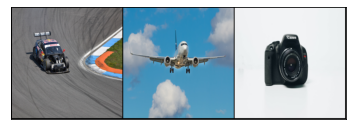

In [12]:
context = ['With one of these I can drive around a track, overtaking other cars and taking corners at speed.',
           'With one of these I can take off from a city and fly across the sky to somewhere on the other side of the world.',
           'With one of these I can']
index = [d['car'], d['plane'], d['camera']]
two_shot_alternating_task(imgs, index, context, ngen=50, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img18>. With one of these I can drill
down into a hole and start digging.

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img18>. With one of these I can drill
down into the earth and <img18>  into the earth.

<img0>. With one of these I can drive around a track, overtaking other cars and taking
corners at speed. <img1>. With one of these I can take off from a city and fly across the
sky to somewhere on the other side of the world. <img18>. With one of these I can drill
holes into the earth and build roads, bridges, tunnels, and even tunnels for the use of
other vehicles.



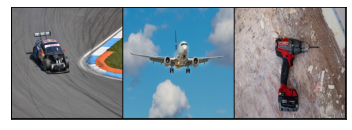

In [13]:
context = ['With one of these I can drive around a track, overtaking other cars and taking corners at speed.',
           'With one of these I can take off from a city and fly across the sky to somewhere on the other side of the world.',
           'With one of these I can']
index = [d['car'], d['plane'], d['drill']]
two_shot_alternating_task(imgs, index, context, ngen=50, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

## Binding examples

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax. <img7>. This photo is a blicket. <img6>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax. <img7>. This photo is a blicket. <img6>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax. <img7>. This photo is a blicket. <img6>. This photo is a dax.



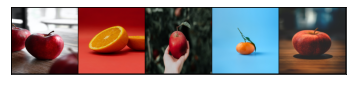

In [14]:
# Two-shot binding
context = ['This photo is a dax.',
           'This photo is a blicket.',
           'This photo is a dax.',
           'This photo is a blicket.',
           'This photo is a']
index = [d['apple'], d['orange'], d['apple2'], d['orange2'], d['apple3']]
two_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='dax', name_b='blicket')

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img7>. This photo is a blicket. <img5>. This photo is a dax. <img8>. This photo is a
blicket.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img7>. This photo is a blicket. <img5>. This photo is a dax. <img8>. This photo is a
blicket.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img7>. This photo is a blicket. <img5>. This photo is a dax. <img8>. This photo is a
blicket.



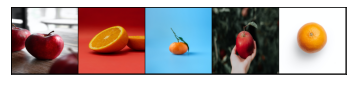

In [15]:
# Flip the ordering
context = ['This photo is a dax.',
           'This photo is a blicket.',
           'This photo is a blicket.',
           'This photo is a dax.',
           'This photo is a']
index = [d['apple'], d['orange'], d['orange2'], d['apple2'], d['orange3']]
two_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='dax', name_b='blicket')

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img7>. This photo is a dax. <img5>. This photo is a blicket. <img8>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img7>. This photo is a dax. <img5>. This photo is a blicket. <img8>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img7>. This photo is a dax. <img5>. This photo is a blicket. <img8>. This photo is a dax.



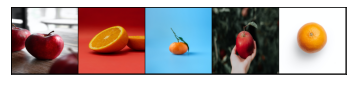

In [16]:
# Flip the words
context = ['This photo is a blicket.',
           'This photo is a dax.',
           'This photo is a dax.',
           'This photo is a blicket.',
           'This photo is a']
index = [d['apple'], d['orange'], d['orange2'], d['apple2'], d['orange3']]
two_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='dax', name_b='blicket')

Answer with martak or subgra. <img3>. This photo is a subgra. <img4>. This photo is a
martak. <img7>. This photo is a martak. <img5>. This photo is a subgra. <img8>. This photo
is a martak.

Answer with martak or subgra. <img3>. This photo is a subgra. <img4>. This photo is a
martak. <img7>. This photo is a martak. <img5>. This photo is a subgra. <img8>. This photo
is a martak.

Answer with martak or subgra. <img3>. This photo is a subgra. <img4>. This photo is a
martak. <img7>. This photo is a martak. <img5>. This photo is a subgra. <img8>. This photo
is a martak.



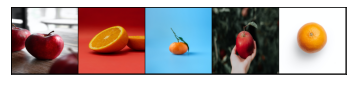

In [17]:
# Change words
context = ['This photo is a subgra.',
           'This photo is a martak.',
           'This photo is a martak.',
           'This photo is a subgra.',
           'This photo is a']
index = [d['apple'], d['orange'], d['orange2'], d['apple2'], d['orange3']]
two_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='martak', name_b='subgra')

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax.

Answer with dax or blicket. <img3>. This photo is a dax. <img4>. This photo is a blicket.
<img5>. This photo is a dax.



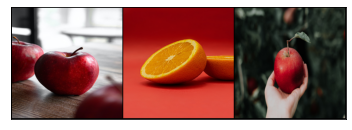

In [18]:
# One-shot binding
context = ['This photo is a dax.',
           'This photo is a blicket.',
           'This photo is a']
index = [d['apple'], d['orange'], d['apple2']]
one_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='dax', name_b='blicket')

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img5>. This photo is a blicket.

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img5>. This photo is a blicket.

Answer with dax or blicket. <img3>. This photo is a blicket. <img4>. This photo is a dax.
<img5>. This photo is a blicket.



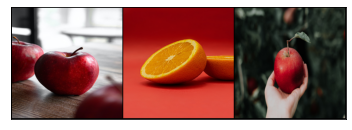

In [19]:
# Flip the words
context = ['This photo is a blicket.',
           'This photo is a dax.',
           'This photo is a']
index = [d['apple'], d['orange'], d['apple2']]
one_shot_binding_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8, name_a='dax', name_b='blicket')

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A dax is made of a clay pot.

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A dax is made of glass.

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A dax is made of a glass, which is an oval, and is made of a clay.



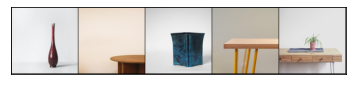

In [20]:
# Two-shot binding QA task
context = ['This is a blicket.',
           'This is a dax.',
           'This is a blicket.',
           'This is a dax.',
           'A dax is made of']
index = [d['vase'], d['table'], d['vase2'], d['table2'], d['flowers']]
two_shot_binding_qa_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A blicket is made of a piece of cloth.

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A blicket is made of glass, and a dax is made of wood.

<img13>. This is a blicket. <img14>. This is a dax. <img15>. This is a blicket. <img16>.
This is a dax. <img17>. A blicket is made of a clay, a piece of clay, a piece of glass,
and a piece of wood.



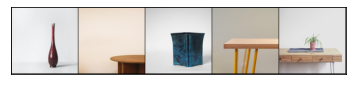

In [21]:
# Ask about the blicket
context = ['This is a blicket.',
           'This is a dax.',
           'This is a blicket.',
           'This is a dax.',
           'A blicket is made of']
index = [d['vase'], d['table'], d['vase2'], d['table2'], d['flowers']]
two_shot_binding_qa_task(imgs, index, context, ngen=20, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

## Knowledge example

<img9>. This was invented by Zacharias Janssen. <img10>. This was invented by Thomas
Edison. <img1>. This was invented by the Wright brothers.

<img9>. This was invented by Zacharias Janssen. <img10>. This was invented by Thomas
Edison. <img1>. This was invented by the Wright brothers.

<img9>. This was invented by Zacharias Janssen. <img10>. This was invented by Thomas
Edison. <img1>. This was invented by the Wright brothers.



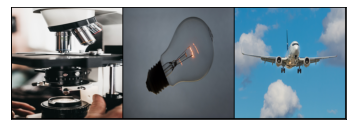

In [22]:
# Knowledge example. Removing "the" produces wrong answers
context = ['This was invented by Zacharias Janssen.',
           'This was invented by Thomas Edison.',
           'This was invented by the']
index = [d['microscope'], d['bulb'], d['plane']]
two_shot_alternating_task(imgs, index, context, ngen=10, sample=True, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

## VQA Examples

<img11>. Question: Which animal is this?. Answer: It is a cow.



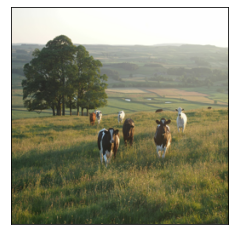

In [23]:
# Zero-shot VQA
context = ['Which animal is this?']
index = [d['cows']]
zero_shot_vqa_task(imgs, index, context, ngen=20, sample=False, nsamples=3, nbeams=3, top_p=0.8, temp=0.8)

<img20>. Question: What is the woman doing?. Answer: She is trying to get the ball out of
the court.



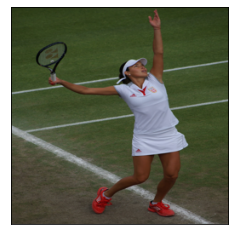

In [24]:
context = ['What is the woman doing?']
index = [d['tennis']]
zero_shot_vqa_task(imgs, index, context, ngen=20, sample=False, nsamples=3, nbeams=3, top_p=0.8, temp=0.8)

<img21>. Question: I have this problem, what can I do?. Answer: If you have a problem with
your water, you should contact your local water company.



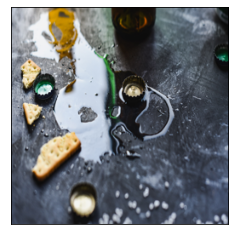

In [25]:
context = ['I have this problem, what can I do?']
index = [d['spill']]
zero_shot_vqa_task(imgs, index, context, ngen=20, sample=False, nsamples=3, nbeams=3, top_p=0.8, temp=0.8)

<img23>. Question: Should I buy the dip?. Answer: Yes, you should buy it.



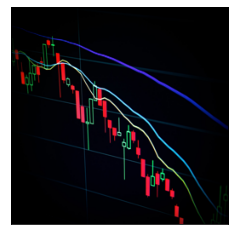

In [26]:
context = ['Should I buy the dip?']
index = [d['stocks']]
zero_shot_vqa_task(imgs, index, context, ngen=20, sample=False, nsamples=3, nbeams=3, top_p=0.8, temp=0.8)

<img24>. Question: What can I do with these?. Answer: You can use them to buy and sell
bitcoins.



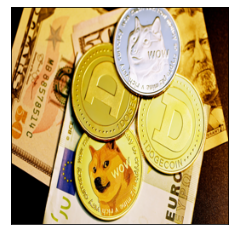

In [27]:
context = ['What can I do with these?']
index = [d['doge']]
zero_shot_vqa_task(imgs, index, context, ngen=20, sample=False, nsamples=3, nbeams=3, top_p=0.8, temp=0.8)

## Image captioning examples

Describe this photo: <img12>. Description: A group of friends and I were on a trip to the
beach. We were all in our swimsuits and we were enjoying the sun. I was wearing a bikini
and my friend was in a bathing suit. The sun was shining and the water was warm. It was a
beautiful day.  The photo was taken by a friend of mine.



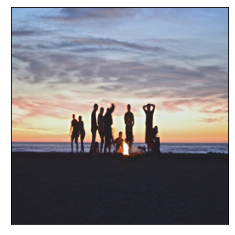

In [28]:
index = [d['beach']]
caption_task(imgs, index, ngen=100, sample=False, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

Describe this photo: <img19>. Description: A protest against the police killing of a young
man in the streets of the city of Táchira, in Venezuela. The protest was organized by the
opposition and the National Assembly.  Source: http://www.youtube.com/watch?v=X2hXqX1QJ_I
.



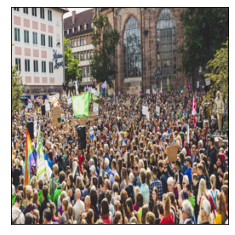

In [29]:
index = [d['protest']]
caption_task(imgs, index, ngen=100, sample=False, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)

Describe this photo: <img22>. Description: This is a battle between the Imperial Guard and
the Orks. The Imperial Guards are outnumbered and outgunned. They are forced to retreat.
Battle of the Black Gate ... ,.



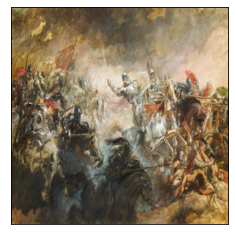

In [30]:
index = [d['art']]
caption_task(imgs, index, ngen=100, sample=False, nsamples=3, nbeams=1, top_p=0.8, temp=0.8)